## 그레디언트 폭주, 소실

앞서 우리는 모델링, 훈련, 훈련방법에 대한 이해를 거쳐왔습니다.

하지만 우리가 앞서 겪을 상황은 모델은 점차 더 깊은 신경망 모델을 사용하거나, 학습해야 할겁니다.

예를 들어 LLM 모델은 이전처럼 얕은 신경망과 다르게 깊은 신경망으로 구성될 가능성이 높습니다.

그렇다면 발생할 가장 이론적인 문제는 그레디언트 폭주, 소실 문제입니다.

각 노드별 그레디언트가 어떻게 계산되는지 생각해보면 언제든 발생할 수 있는 문제임이 이해됩니다.

역전파를 통해 하위층으로 그레이언트를 전파할수록 그레디언트가 굉장히 작아지거나(소실), 발산해버릴 수 있습니다(폭주)

### 활성화 함수별 초기화 전략

이런 문제의 해결방법 중 하나는 다음과 같은 랜덤초기화 방법이 제시되었습니다.

#### 글로럿 초기화

> 추천 :  활성화 함수 없을경우, tanh, 로지스틱, 소프트맥스

평균이 0이고 분산이 $\frac{1}{fan_{avg}}, \quad where \quad fan_{avg}=\frac{fan_{in}+fan_{out}}{2}$

혹은 $r= \sqrt{\frac{3}{fan_{avg}}}$ 인 $(-r,r)$의 균등분포 

(여기서 $fan_{in}$은 입력층의 연결개수, $fan_{out}$은 출력층의 연결개수 입니다.)

#### 르쿤 초기화

> 추천 : SELU

위의 글로럿 초기화에서 $fan_{avg}$를 $fan_{in}$으로 바꾸는 것입니다.

#### HE 초기화

> 추천 :  Relu, LeakyRelu, ELU, GELU, Swish, Mish

위의 글로럿 초기화에서 $fan_{avg}$를 $fan_{in}/2$으로 바꾸는 것입니다.

#### 초기화 설정

케라스에서 기본적으로 균등분포의 글로럿 초기화를 사용합니다

In [2]:
import keras

In [3]:
test_layer=keras.layers.Dense(units=1,activation=None)

In [7]:
test_layer.get_config()["kernel_initializer"]

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

In [8]:
# 위의 글로럿 초기화을 다음과 같이 적용할 수 있습니다
initialize=keras.initializers.glorot_uniform()
test_layer=keras.layers.Dense(units=1,activation=None,kernel_initializer=initialize)

In [9]:
test_layer.get_config()["kernel_initializer"]

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

In [11]:
# 사용자 정의로 가능합니다.(He 초기화 예시)
initialize=keras.initializers.VarianceScaling(scale=2,mode="fan_in",distribution="truncated_normal")

### 고급 활성화 함수

또 다른 선택으로는 활성화 함수에 있습니다.

RELU의 단점으로 `dying RELU` 문제가 있습니다.

이는 훈련동안 일부 뉴런이 0 이외의 값을 출력하지 않는 문제입니다.

따라서 다양한 RELU 함수의 변형들이 존재하는데 일부만 알아보자

#### Leaky RELU

$LeakyRELU(x)=max(\alpha x,x)$

$\alpha$는 LeakyRELU가 죽지 않게 해줍니다.

이는 뉴런이 혼수상태(유사 죽음상태)에 오래 있을순 있지만, 다시 꺠어날 가능성을 얻게 해줍니다. 

In [33]:
import tensorflow as tf
x=tf.range(start=-3,limit=3,delta=0.1)
leaky_=keras.activations.leaky_relu(x,negative_slope=0.2)

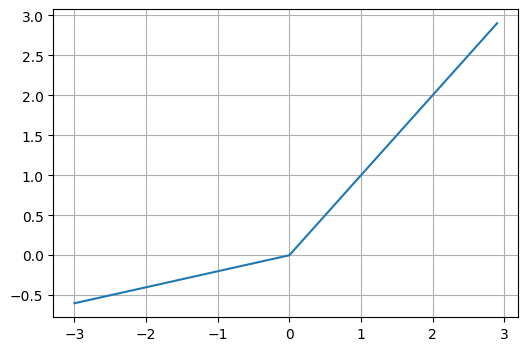

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(x,leaky_)
plt.grid()

#### ELU

RELU 함수의 부드러운 변형입니다.

단점은 수렴속도는 빠를지 언정(실제로 빠릅니다) 지수함수 사용으로 인한 계산속도 저하에 있습니다.

$ELU_{\alpha}(z)=\alpha(exp(z)-1) ,\quad z<0 $

$z, \quad z>0$

#### SELU

다음과 같은 제약조건 하에 굉장히 강력한 성능을 보여준 활성화 함수입니다.

(대략적으로 $SELU(z)=1.05 *ELU_{(1.67)}(z)$)

- 1. 입력특성이 반드시 표준화되어있어야합니다.
- 2. 모든 은닉층의 가중치는 르쿤 정규분포 초기화를 적용해야합니다.
- 3. $l_{1}, l_2$,맥스-노름, 배치정규화, 드롭아웃과 같은 규제를 가할 수 없습니다.
- 4. 일반적인 완전연결 MLP 여야만 '자기정규성' 특성을 가집니다.

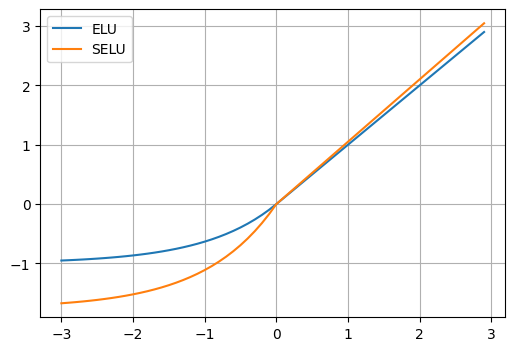

In [39]:
elu_=keras.activations.elu(x,alpha=1)
selu_=keras.activations.selu(x)
plt.figure(figsize=(6,4))
plt.plot(x,elu_,label="ELU")
plt.plot(x,selu_,label="SELU")
plt.legend()
plt.grid()

#### Swish

$Swish_{\beta}(z)=z \sigma(\beta z)$, 여기서 $\sigma$는 시그모이드 함수입니다

#### Mish

$mish(z)=z tanh(softplus(z))$ , 여기서 $softplus(z)=\log{(1+\exp(z))}$입니다.

In [36]:
swish_=keras.activations.swish(x)
mish_=keras.activations.mish(x)

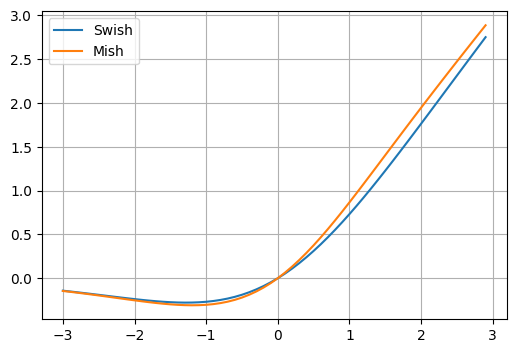

In [38]:
plt.figure(figsize=(6,4))
plt.plot(x,swish_,label="Swish")
plt.plot(x,mish_,label="Mish")
plt.legend()
plt.grid()

### 배치 정규화(BN)

활성화 함수의 선택과 초기화 전략을 통해 훈련 초기단계의 그레디언트 문제를 크게 줄일 수 있지만,

훈련도중 이 문제가 다시 발생하지 않으라는 보장은 없습니다.

이에 대한 해결로 각 층에서 입력 전, 출력 후 연산을 추가합니다.

입력데이터를 원점으로 맞추고 정규화하는 것입니다.

심지어 `keras`의 배치 정규화는 최종 통계의 입력데이터의 평균과 분산을 예측합니다.

성능면에서도, 최종적인 속도(계산속도는 증가하지만 수렴속도가 빨라짐) 면에서도, 굉장한 이점을 가집니다.

더군다나, 규제와 같은 역할을 하여, 다른 규제의 필요성을 낮춥니다.

In [42]:
from zipfile import ZipFile
import pandas as pd
import io
with ZipFile("../Data/고객 대출등급 분류 해커톤.zip","r") as f:
    data=io.BytesIO(f.read("고객 대출등급 분류 해커톤/train.csv"))

data=pd.read_csv(data)

from sklearn import model_selection as mod
import numpy as np

num_cols=list(data.select_dtypes(np.number).columns)

use_feature=data[num_cols]
label_list=data.대출등급.unique()
label_list.sort()

use_label=data.대출등급.map(lambda label : np.argmax(label_list==label))

train_feature,test_feature,train_label,test_label=mod.train_test_split(
    use_feature,use_label,train_size=0.9,stratify=use_label,random_state=1)

자기 정규화

In [49]:
from sklearn import preprocessing as pre
standard_scaler=pre.StandardScaler()
standard_scaler.fit(use_feature)

standard_feature=standard_scaler.transform(use_feature)

In [55]:
# label 은 위의 훈련,테스트 데이터셋과 동일합니다
standard_train_feature,standard_test_feature,_,_=mod.train_test_split(
    standard_feature,use_label,train_size=0.9,stratify=use_label,random_state=1)

In [64]:
standard_train_feature

array([[-1.307384  , -0.79871617, -0.21685205, ..., -0.91559337,
        -0.03843798, -0.07259526],
       [ 0.01703955, -0.40099879, -0.26600398, ...,  0.35135998,
        -0.03843798, -0.07259526],
       [ 2.29411865,  0.98498601,  0.08044264, ...,  0.69595101,
        -0.03843798, -0.07259526],
       ...,
       [ 0.55145608,  0.14134309,  0.15848995, ..., -0.28861815,
        -0.03843798, -0.07259526],
       [-0.02943145,  0.17749921, -0.00356247, ...,  0.31698538,
        -0.03843798, -0.07259526],
       [ 0.04027506, -0.461259  ,  0.18857689, ..., -0.06508786,
        -0.03843798, -0.07259526]])

In [107]:
use_activation=keras.activations.selu
initializer=keras.initializers.lecun_normal()

Simple_Model=keras.Sequential()
for _ in range(5):
    Simple_Model.add(
        keras.layers.Dense(64,activation=use_activation,kernel_initializer=initializer)
    )
Simple_Model.add(
    keras.layers.Dense(7,activation="softmax",kernel_initializer=initializer)
)

optimizer=keras.optimizers.AdamW()
loss=keras.losses.SparseCategoricalCrossentropy()
metric_list=[keras.metrics.SparseCategoricalAccuracyCategoricalAccuracy()]

Simple_Model.compile(optimizer=optimizer,loss=loss,metrics=metric_list)

In [93]:
callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)]
Simple_Model.fit(x=standard_train_feature,y=train_label.values,batch_size=16,epochs=10,validation_data=(standard_test_feature,test_label.values),
                 callbacks=callbacks)

Epoch 1/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - loss: 0.9841 - sparse_categorical_accuracy: 0.5865 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.7020
Epoch 2/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.6286 - val_sparse_categorical_accuracy: 0.7529
Epoch 3/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - loss: 0.6130 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.6026 - val_sparse_categorical_accuracy: 0.7664
Epoch 4/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - loss: 0.5860 - sparse_categorical_accuracy: 0.7724 - val_loss: 0.5514 - val_sparse_categorical_accuracy: 0.7922
Epoch 5/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - loss: 0.5608 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.5569 - val_sparse_categorical_accuracy: 0.7781
Epoch 6/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - loss: 0.5326 - sparse_categorical_accuracy: 0.7950 - val_loss: 0.5270 - val_sparse_categoric

성능이 굉장히 좋습니다. 심지어 아직 수렴하지 않았죠

In [94]:
probas=Simple_Model.predict(standard_test_feature)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [80]:
from sklearn import metrics as met

In [105]:
met.accuracy_score(test_label.values,tf.argmax(probas,axis=-1).numpy())

0.8272066458982347

In [106]:
met.confusion_matrix(test_label.values,tf.argmax(probas,axis=-1).numpy())

array([[1359,  295,   23,    0,    0,    0,    0],
       [ 129, 2479,  258,   12,    4,    0,    0],
       [  12,  215, 2369,  158,    2,    7,    0],
       [   4,   34,  101, 1113,   80,    3,    1],
       [   0,   21,   39,  181,  471,   22,    1],
       [   0,    6,   12,    1,   18,  150,    8],
       [   0,    3,    0,    1,    0,   13,   25]])

배치정규화

In [110]:
use_activation=keras.activations.swish
initializer=keras.initializers.he_normal()
softmax_initializer=keras.initializers.glorot_normal()

Simple_Model_batch=keras.Sequential([keras.layers.BatchNormalization()])
for _ in range(5):
    Simple_Model_batch.add(
        keras.layers.Dense(64,activation=use_activation,kernel_initializer=initializer,use_bias=False)
    )
    Simple_Model_batch.add(
        keras.layers.BatchNormalization()
    )
    
Simple_Model_batch.add(
    keras.layers.Dense(7,activation="softmax",kernel_initializer=softmax_initializer)
)

optimizer=keras.optimizers.AdamW()
loss=keras.losses.SparseCategoricalCrossentropy()
metric_list=[keras.metrics.SparseCategoricalAccuracy()]

Simple_Model_batch.compile(optimizer=optimizer,loss=loss,metrics=metric_list)

In [113]:
callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)]
Simple_Model_batch.fit(x=train_feature,y=train_label.values,batch_size=16,epochs=10,validation_data=(test_feature,test_label.values),
                 callbacks=callbacks)

Epoch 1/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 115s 21ms/step - loss: 1.1745 - sparse_categorical_accuracy: 0.4900 - val_loss: 1.4190 - val_sparse_categorical_accuracy: 0.5003
Epoch 2/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 118s 22ms/step - loss: 1.0450 - sparse_categorical_accuracy: 0.5385 - val_loss: 1.6127 - val_sparse_categorical_accuracy: 0.4580
Epoch 3/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 1.0289 - sparse_categorical_accuracy: 0.5468 - val_loss: 1.3548 - val_sparse_categorical_accuracy: 0.5265
Epoch 4/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 118s 22ms/step - loss: 0.9958 - sparse_categorical_accuracy: 0.5623 - val_loss: 1.1613 - val_sparse_categorical_accuracy: 0.5451
Epoch 5/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 118s 22ms/step - loss: 1.0035 - sparse_categorical_accuracy: 0.5591 - val_loss: 1.3910 - val_sparse_categorical_accuracy: 0.5229
Epoch 6/10
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 0.9933 - sparse_categorical_accuracy: 0.5637 - val_loss: 1.4801 - val_sparse_cat

#### BatchNormalization

일반적으로 기본값을 사용하지만 두가지 파라미터를 알고있어야합니다.

1. 모멘텀(momentum)
2. 축(axis)

배치정규층은 아래와 같은 4개의 변수를 학습합니다.
(정확하게는 $\gamma,\beta$ 만 학습합니다.)

In [122]:
[var.name for var in Simple_Model_batch.layers[0].variables]

['gamma', 'beta', 'moving_mean', 'moving_variance']

$\hat v_{i+1}=momentum * \hat{v_{i}} + (1-momentum)*v$, 여기서 $v$는 입력평균 벡터와 표준편차 벡터를 나타냅니다

axis 는 위의 정규화를 적용할 축을 결정합니다

### 그레디언트 클리핑

위처럼 배치정규(BN)을 사용하기 어려운 상황에서 채택되는 방법입니다.

이 방법은 역전파될 때 특정 임계값을 넘어서지 못하게 그레디언트를 잘라냅니다.

1. clipvalue : 임계값을 넘어가는 수치의 최대,최소값을 지정합니다.
2. clipnorm : $l_{2}$ 노름의 값을 해당 값으로 고정합니다

In [123]:
keras.optimizers.SGD(clipvalue=1)

다만 이 방법은 그레디언트의 크기를 추적할 수 있어야합니다.

이는 이후 텐서보드에서 다루겠습니다.